In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# import folium
from ast import literal_eval
import json


import ast

import sys
import os


import matplotlib.gridspec as gridspec
# import folium
# from folium import FeatureGroup
from matplotlib import style
style.use('seaborn-darkgrid')


# import keplergl



from datetime import datetime

from sklearn import preprocessing


%matplotlib inline
# sns.set_style("seaborn-darkgrid")

# read data

## K-means results

In [8]:
kmean_results_labels = pd.read_csv(
     'results/kmeans_results_all_TimeZoneCorrected_08202021.csv')
# kmean_results

kmean_results=pd.read_csv('_Data/model data/model_data_TimeZoneCorrected_08192021.csv') #model_data_TimeZoneCorrected_08192021.csv')
# PCA_model_data


kmean_results['KMeans_16_labels']=literal_eval(kmean_results_labels[kmean_results_labels['Cluster_no']
             == 16]['Kmeans_label_list'].values.tolist()[0])

kmean_results.head()

,Unnamed: 0,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,...,StartTime_AMPeak,StartTime_Day,StartTime_PMPeak,StartTime_Night,weekend_trip,high_trip_count_day,DATE_str,PRCP,TAVG,KMeans_16_labels
0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,...,1,0,0,0,0,0,2018-09-01,0.02,79,9
1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,...,1,0,0,0,0,0,2018-09-01,0.02,79,9
2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,1,0,0,0,0,0,2018-09-01,0.02,79,9
3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,...,1,0,0,0,0,0,2018-09-01,0.02,79,9
4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,1,0,0,0,0,0,2018-09-01,0.02,79,9


In [20]:
# kmean_results = pd.read_csv(
#     '_Data/Model results/kmean_predictions.csv')


kmean_results['StartTime_decimal'] = kmean_results.apply(
    lambda x: x['StartTime_decimal'] + 24
    if x['StartTime_decimal'] <= 6 else x['StartTime_decimal'],
    axis=1)

#add flag for trips starting or ending at Vanderbilt and Parks
kmean_results['VANDERBILT_trip'] = kmean_results.apply(
    lambda x: 1
    if (x['VANDERBILT_start'] == 1) | (x['VANDERBILT_end'] == 1) else 0,
    axis=1)


kmean_results['PARK_trip'] = kmean_results.apply(
    lambda x: 1
    if (x['PARK_start'] == 1) | (x['PARK_end'] == 1) else 0,
    axis=1)

print(kmean_results.shape)
print(kmean_results.columns)
kmean_results.head()

(1050497, 50)
Index(['Unnamed: 0', 'trip_id', 'GRID_ID_start', 'GRID_ID_end',
       'enthropy_start', 'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_SU_start',
       'MEAN_RURAL_start', 'MEAN_POP_D_start', 'MEAN_EMP_D_start',
       'MEAN_PAKING_start', 'intersection_density_start', 'enthropy_end',
       'MEAN_CBD_end', 'MEAN_URBAN_end', 'MEAN_SU_end', 'MEAN_RURAL_end',
       'MEAN_POP_D_end', 'MEAN_EMP_D_end', 'MEAN_PAKING_end',
       'intersection_density_end', 'PARK_start', 'VANDERBILT_start',
       'NISSAN_start', 'PARK_end', 'VANDERBILT_end', 'NISSAN_end',
       'tripDistance_miles', 'tripDistance', 'tripDuration',
       'euclidean_distance', 'StartTime_decimal', 'route_directness_rawDist',
       'route_directness_trace', 'average_trip_speed_mph',
       'trip_start_week_no', 'trip_start_hour_no', 'StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night', 'weekend_trip',
       'high_trip_count_day', 'DATE_str', 'PRCP', 'TAVG', 'KMeans_16_labels',
   

,Unnamed: 0,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,...,StartTime_PMPeak,StartTime_Night,weekend_trip,high_trip_count_day,DATE_str,PRCP,TAVG,KMeans_16_labels,VANDERBILT_trip,PARK_trip
0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,...,0,0,0,0,2018-09-01,0.02,79,9,0,0
1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,...,0,0,0,0,2018-09-01,0.02,79,9,0,1
2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,0,0,2018-09-01,0.02,79,9,0,0
3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,...,0,0,0,0,2018-09-01,0.02,79,9,0,0
4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,0,0,2018-09-01,0.02,79,9,0,0


## Trip data

In [24]:
trip_data = pd.read_csv(
    '_Data/trip data/start_end_points_cleaned_TimeZoneCorrected_08192021.csv')
trip_data['startDateTime'] = pd.to_datetime(
    trip_data['startDateTime'], utc=True).dt.tz_convert('US/Central')

# trip_data['KMeans_16_labels']=literal_eval(kmean_results_labels[kmean_results_labels['Cluster_no']
#              == 16]['Kmeans_label_list'].values.tolist()[0])
trip_data_merged_label=pd.merge(trip_data,
        kmean_results[['trip_id','KMeans_16_labels']],
        how='left',
        on='trip_id')
trip_data_merged_label.to_csv('_Data/model data/model_results (coords and label)_TimeZoneCorrected_08192021.csv')
trip_data_merged_label.head()

,Unnamed: 0,trip_id,startLatitude,startLongitude,endLatitude,endLongitude,weekend_trip,startDateTime,tripRoute,KMeans_16_labels
0,1,9,36.1651,-86.7785,36.1622,-86.7683,0,2018-09-01 07:13:22-05:00,"[[36.165096,-86.778367],[36.165091,-86.778374]...",9.0
1,2,10,36.1760,-86.7871,36.1733,-86.7857,0,2018-09-01 07:14:46-05:00,"[[36.176036,-86.787034],[36.176036,-86.787034]...",9.0
2,3,11,36.1643,-86.7770,36.1750,-86.7819,0,2018-09-01 07:15:11-05:00,"[[36.164271,-86.777062],[36.164271,-86.777062]...",9.0
3,4,12,36.1642,-86.7811,36.1647,-86.7803,0,2018-09-01 07:46:21-05:00,"[[36.164203,-86.78109],[36.164203,-86.78109],[...",9.0
4,5,13,36.1643,-86.7771,36.1749,-86.7819,0,2018-09-01 07:18:32-05:00,"[[36.164336,-86.777085],[36.164336,-86.777085]...",9.0


In [26]:
kmeans_results_linkCoords=pd.merge(kmean_results,
         trip_data[['trip_id','startLatitude','startLongitude','endLatitude',
                    'endLongitude','weekend_trip','startDateTime']],
         on='trip_id',
         how='left')
kmeans_results_linkCoords.to_csv('_Data/model data/ClusteringResults_Interpretation_TimeZoneCorrected_08222021_v1.csv')       


# Visualizing clustering results

In [51]:
def plot_graph(cluster_df, selected_cluster, variable_to_plot, title, ax,
               plot_upper_bound, x_label):
    #PURPOSE: Plot kdeplot of a single variable for all cluster type
    #INPUT
    ####ax = axis of gridspec
    ####title: title of the plot
    ####cluster_df: Dataframe with cluster id
    ####selected_cluster: cluster to plot
    ####variable_to_plot: name of the variable to plot
    ####plot_upper_bound: upper bound of the plot
    #OUTPUT: plt plot

    #fig, ax = plt.subplots(figsize=(6,4))

    #run a loop for all the sorted unique values in cluster
    for i in sorted(cluster_df[selected_cluster].unique()):
        #plot kdeplot for each clusters in same plot
        sns.kdeplot(
            cluster_df[cluster_df[selected_cluster] == i][variable_to_plot],
            label=str('C' + str(i)),
            ax=ax)
    ax.set_title(title, fontsize=10)

    ax.legend(fontsize=8, ncol=2)

    ax.axis([0, plot_upper_bound, None, None])
    ax.set_ylabel('Probability', fontsize=9)
    ax.set_xlabel(x_label, fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #return plt


def spyder_plot_for_cluster(cluster_results, cluster_var_col_name,
                            cluster_number, ax, plot_color, var_median,
                            var_mean):

    var_spyder_all = var_median + var_mean
    #slice variable of interest
    data_for_sypder_plot = cluster_results[var_spyder_median + var_spyder_mean]

    #     cluster_var_col_name = str('kmeans_' + str(kmeans_cluster_no))

    #standarize the data
    scaler = preprocessing.MinMaxScaler()
    data_for_sypder_plot_scaled = pd.DataFrame(
        scaler.fit_transform(data_for_sypder_plot), columns=var_spyder_all)
    data_for_sypder_plot_scaled[cluster_var_col_name] = cluster_results[
        cluster_var_col_name]

    #get dataframe of one cluster
    cluster = data_for_sypder_plot_scaled[
        data_for_sypder_plot_scaled[cluster_var_col_name] ==
        cluster_number][var_spyder_all]

    #     #standarize the data
    #     scaler = preprocessing.MinMaxScaler()
    #     cluster = pd.DataFrame(scaler.fit_transform(cluster_0), columns=var_spyder_all)

    labels = np.arange(1,
                       len(np.array(var_spyder_all)) + 1,
                       1)  #np.array(var_spyder_all)

    #concate mean and median columns and sum them to get one column
    stats = pd.concat([
        cluster.loc[:, var_spyder_median].median(axis=0),
        cluster.loc[:, var_spyder_mean].mean(axis=0)
    ],
                      axis=1)
    stats = stats.sum(axis=1)

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    # close the plot
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()
    #     ax = fig.add_subplot(111, polar=True)
    ax.plot(angles,
            stats,
            'o-',
            markersize=2,
            linewidth=1.5,
            color=plot_color,
            label=str('C' + str(cluster_number)))
    ax.fill(angles, stats, alpha=0.05)
    ax.set_thetagrids(angles[:19] * 180 / np.pi, labels)
    ax.set_yticklabels([])
    #     ax.set_title(str('C' + str(cluster_number)))
    ax.grid(True)
#     ax.legend()


In [96]:
var_spyder_median = [
    'tripDistance_miles',
    'tripDuration',
    'route_directness_trace',
    'average_trip_speed_mph',

        'TAVG',
    'MEAN_CBD_start',
    'MEAN_URBAN_start',
    'MEAN_POP_D_start',
    'MEAN_EMP_D_start',
    'MEAN_PAKING_start',
    #     'intersection_density_start',
    'enthropy_start',
    'MEAN_CBD_end',
    'MEAN_URBAN_end',
    'MEAN_POP_D_end',
    'MEAN_EMP_D_end',
    'MEAN_PAKING_end',
    #     'intersection_density_end',
    'enthropy_end'
]

var_spyder_mean = ['high_trip_count_day', 'weekend_trip']

var_spyder_all = var_spyder_median + var_spyder_mean

## Trip start time by clusters

### Clusterd by sequence

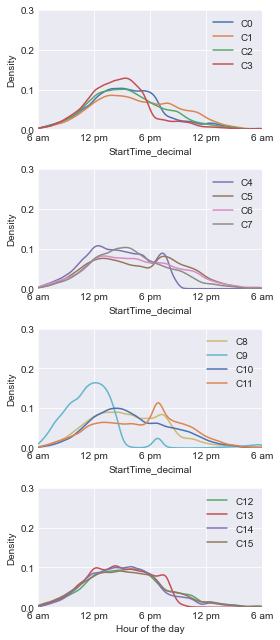

In [59]:




selected_cluster = 'KMeans_16_labels'
total_clusters = 16
clusters_per_plot = 3
number_of_plot = 4
plot_split = [0, 3, 7, 11, 15]

style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(4, 9))
#fig.suptitle('K mean cluster 10')

gspec = gridspec.GridSpec(number_of_plot, 1)

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)

for i in np.arange(0, total_clusters, 1):
    if (i <= plot_split[1]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[0, 0]))

    elif (i <= plot_split[2]) & (i > plot_split[1]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[1, 0]))
    elif (i <= plot_split[3]) & (i > plot_split[2]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[2, 0]))
    elif (i <= plot_split[4]) & (i > plot_split[3]):
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == i]
                    ['StartTime_decimal'],
                    clip=(0, 30),
                    label=str('C' + str(i)),
                    color=custom_palette[i],
                    ax=plt.subplot(gspec[3, 0]))

    plt.xlim(6, 30)
    plt.xticks(np.arange(6, 31, 6),['6 am','12 pm','6 pm','12 pm', '6 am'])
    

#     plt.xticks(np.arange(6, 25, 6))
    plt.yticks(np.arange(0, 0.4, 0.1))
    plt.legend()
plt.tight_layout()
plt.xlabel('Hour of the day')

plt.savefig(str('results/cluster_time_of_day.png'), dpi=900)

# plt.savefig('plots/DailyTrips_Year.png', dpi=900)

### Clustered by group

<ipython-input-98-525412f03833>:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchs" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(str('results/cluster_time_of_day_TimeZoneCorrected_grouped_V1.png'),


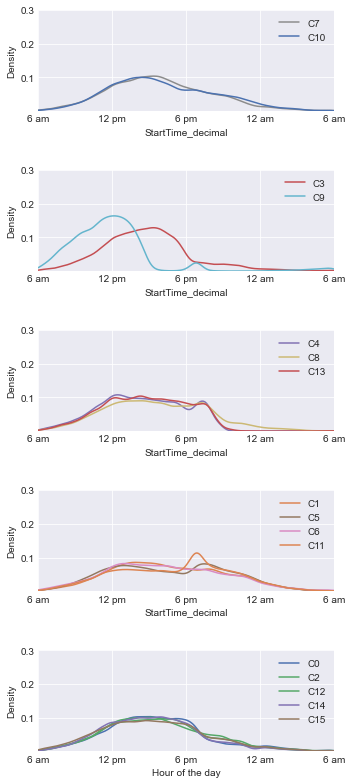

In [98]:
selected_cluster = 'KMeans_16_labels'
total_clusters = 16
number_of_plot = 5


#group clusters by id

grouped_cluster_labels=['Group1','Group 2','Group 3','Group 4','Group 5']
dayTime_ShortErrand=[7,10]
utilitarian = [3,9]
evening_Social = [4,8,13]
entertainment_District = [1,5,6,11]
recreational =[0,2,12,14,15]
grouped_clusters = [
    dayTime_ShortErrand, utilitarian, evening_Social, entertainment_District,
    recreational
]


style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(5, 11))
gspec = gridspec.GridSpec(number_of_plot, 1)




grouped_clusters = [
    dayTime_ShortErrand, utilitarian, evening_Social, entertainment_District,
    recreational
]

for grouped_id in np.arange(len(grouped_clusters)):
    for individual_cluster in grouped_clusters[grouped_id]:
        sns.kdeplot(kmean_results[kmean_results[selected_cluster] == individual_cluster]
            ['StartTime_decimal'],
            clip=(0, 30),
            label=str('C' + str(individual_cluster)),
            color=custom_palette[individual_cluster],
            ax=plt.subplot(gspec[grouped_id, 0]))

#     plt.title(grouped_cluster_labels['grouped_id'])
    #add axis labels and ticks
    plt.xlim(6, 30)
    plt.xticks(np.arange(6, 31, 6),['6 am','12 pm','6 pm','12 am', '6 am'])
   
#     plt.xticks(np.arange(6, 25, 6))
    plt.yticks(np.arange(0, 0.4, 0.1), ['','0.1','0.2','0.3'])

    plt.legend()
plt.tight_layout(h_pad=3.0)
plt.xlabel('Hour of the day')

plt.savefig(str('results/cluster_time_of_day_TimeZoneCorrected_grouped_V1.png'),
            bbox_inchs='tight', dpi=900)



## Radar plot for cluster attributes

https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way/data

### clustered by sequence

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (11).

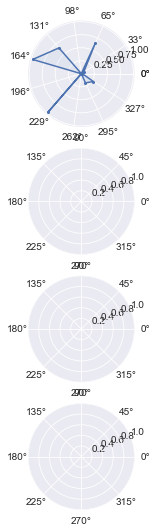

<Figure size 432x288 with 0 Axes>

In [53]:



fig = plt.figure(figsize=(4, 9))
#fig.suptitle('K mean cluster 10')

gspec = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gspec[0, 0], polar=True)
ax1 = plt.subplot(gspec[1, 0], polar=True)
ax2 = plt.subplot(gspec[2, 0], polar=True)
ax3 = plt.subplot(gspec[3, 0], polar=True)

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)

for i in np.arange(0, total_clusters, 1):
    if (i <= plot_split[1]):
        spyder_plot_for_cluster(kmean_results,
                        selected_cluster,
                        i,
                        ax0,
                        custom_palette[i],
                        var_spyder_median,
                        var_spyder_mean)
    elif (i <= plot_split[2]) & (i > plot_split[1]):
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax1,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)
    elif (i <= plot_split[3]) & (i > plot_split[2]):
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax2,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)        
    elif (i <= plot_split[4]) & (i > plot_split[3]): 
        spyder_plot_for_cluster(kmean_results,
                selected_cluster,
                i,
                ax3,
                custom_palette[i],
                var_spyder_median,
                var_spyder_mean)        
fig.tight_layout()       

fig.savefig(str('results/cluster_attributes_TimeZoneCorrected.png'),dpi=900)

### Clustered by group

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (6).

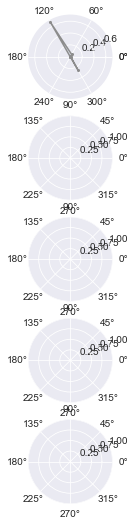

<Figure size 432x288 with 0 Axes>

In [99]:
var_spyder_median = [
    'tripDistance_miles',
    'tripDuration',
    'route_directness_trace',
    'average_trip_speed_mph'

#         'TAVG',
#     'MEAN_CBD_start',
#     'MEAN_URBAN_start',
#     'MEAN_POP_D_start',
#     'MEAN_EMP_D_start',
#     'MEAN_PAKING_start',
#     #     'intersection_density_start',
#     'enthropy_start',
#     'MEAN_CBD_end',
#     'MEAN_URBAN_end',
#     'MEAN_POP_D_end',
#     'MEAN_EMP_D_end',
#     'MEAN_PAKING_end',
#     #     'intersection_density_end',
#     'enthropy_end'
]

var_spyder_mean = ['high_trip_count_day', 'weekend_trip']

var_spyder_all = var_spyder_median + var_spyder_mean


style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(4, 9))

#defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)



gspec = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gspec[0, 0], polar=True)
ax1 = plt.subplot(gspec[1, 0], polar=True)
ax2 = plt.subplot(gspec[2, 0], polar=True)
ax3 = plt.subplot(gspec[3, 0], polar=True)
ax4 = plt.subplot(gspec[4, 0], polar=True)

ax=[ax0, ax1, ax2, ax3, ax4]


custom_palette = sns.color_palette("deep", total_clusters)

for grouped_id in np.arange(len(grouped_clusters)):
    for individual_cluster in grouped_clusters[grouped_id]:
        #defind colour pallet
        spyder_plot_for_cluster(kmean_results,
                        selected_cluster,
                        individual_cluster,
                        ax[grouped_id],
                        custom_palette[individual_cluster],
                        var_spyder_median,
                        var_spyder_mean)

fig.tight_layout(pad=3)

fig.savefig(str('results/cluster_attributes_TimeZoneCorrected-grouped_V1.png'), dpi=900)

# plt.savefig('plots/DailyTrips_Year.png', dpi=900)

### Radar chart by variable

In [181]:
plot_var_spyder=[    'tripDistance_miles',
    'tripDuration',
    'route_directness_trace',
    'average_trip_speed_mph']
plot_var_spyder_labels=[*plot_var_spyder, plot_var_spyder[0]]


kmean_results_df=kmean_results[plot_var_spyder+['KMeans_16_labels']].groupby(
    'KMeans_16_labels').mean().T#.reset_index()
kmean_results_df

#var name
var_name='average_trip_speed_mph'

def plot_spider_byVar(var_name,)

labels=[str('C'+str(col)) for col in kmean_results_df.columns]
stats=kmean_results_df.loc[var_name,].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# close the plot
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))
labels=np.concatenate((labels,[labels[0]]))
print(len(stats))
print(len(angles))
print(len(labels))
# labels

17
17
17


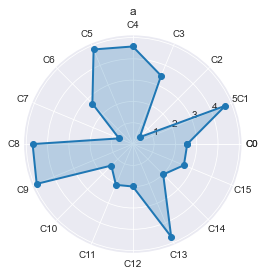

In [182]:


fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('a')
ax.grid(True)


In [16]:
rename_variables = {
    'tripDistance_miles': 'Trip distance (miles)',
    'tripDuration': 'Trip duration (minutes)',
    'route_directness_trace': 'Route directness ratio',
    'average_trip_speed_mph': 'Average trip speed (mph)',
    'high_trip_count_day': 'Trips on special event',
    'weekend_trip': 'Weekend trips',
    'StartTime_AMPeak': 'Trip during 7 am and 10 am',
    'StartTime_Day': 'Trip during 10 am and 4 pm',
    'StartTime_PMPeak': 'Trip during 4 pm and 8 pm',
    'StartTime_Night': 'Trip during 8 pm and 7 am',
    'PRCP': 'Average daily precipitation',
    'TAVG': 'Average daily temperature',
    'MEAN_CBD_start': 'Proportion of CBD land use at origin',
    'MEAN_URBAN_start': 'Proportion of urban land use at origin',
    'MEAN_SU_start': 'Proportion of sub-urban land use at origin',
    'MEAN_RURAL_start': 'Proportion of rural land use at origin',
    'MEAN_POP_D_start': 'Average population density at origin',
    'MEAN_EMP_D_start': 'Average employment density at origin',
    'MEAN_PAKING_start': 'Average parking density at origin',
    'intersection_density_start':
    'Intersection density (per sq. miles) at origin',
    'enthropy_start': 'Entropy at origin',
    'MEAN_CBD_end': 'Proportion of CBD land use at destination',
    'MEAN_URBAN_end': 'Proportion of urban land use at destination',
    'MEAN_SU_end': 'Proportion of sub-urban land use at destination',
    'MEAN_RURAL_end': 'Proportion of rural land use at destination',
    'MEAN_POP_D_end': 'Average population density at destination',
    'MEAN_EMP_D_end': 'Average employment density at destination',
    'MEAN_PAKING_end': 'Average parking density at destination',
    'intersection_density_end':
    'Intersection density (per sq. miles) at destination',
    'enthropy_end': 'Entropy at destination'
}

for x,y in zip( np.arange(1,len(np.array(var_spyder_all))+1,1),np.array(var_spyder_all)):
    print('{0}: {1}'.format(x,rename_variables[y]))

NameError: name 'var_spyder_all' is not defined

# Redefine clusters

https://www.youtube.com/watch?v=T2mQiesnx8s

In [ ]:
day_errand = [5, 8, 14]  #1
utilitarian_trips = [1, 2, 3]  #2
social = [6, 9, 13]  #3
bar_hopping = [4, 7, 10]  #4
social_recreational = [0, 11, 12, 15]  #5

reclassify_cluster_label=['Daytime short errand', 'Utilitarian', 'Evening social',
                         'Night-time Entertainment District', 'Recreational']


def reclassify_cluster(cluster_value_for_reclassify):
    if cluster_value_for_reclassify in day_errand:
        return 0
    if cluster_value_for_reclassify in utilitarian_trips:
        return 1
    if cluster_value_for_reclassify in social:
        return 2
    if cluster_value_for_reclassify in bar_hopping:
        return 3
    if cluster_value_for_reclassify in social_recreational:
        return 4




kmean_results['reclassified_cluster'] = kmean_results.apply(
    lambda x: reclassify_cluster(x['kmeans_16']), axis=1)

kmean_results.head()

## Regrouped cluster results in table 

In [21]:
var_spyder_all = var_spyder_median + var_spyder_mean

cluster_number = 16
selected_cluster_to_group = ['KMeans_16_labels']#['reclassified_cluster']



#descriptive stats
summary_median = kmean_results[var_spyder_median +
                               selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                   [np.mean])
summary_mean = kmean_results[var_spyder_mean +
                             selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                 [np.mean])

summary = pd.concat([summary_median, summary_mean], axis=1)


total_special_trips=kmean_results.groupby(selected_cluster_to_group[0])['high_trip_count_day'].sum().sum()
special_trips_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['high_trip_count_day'].sum()
summary['proportion_of_special_day_trip'] = special_trips_by_cluster/total_special_trips*100

vanderbilt_trips=kmean_results.groupby(selected_cluster_to_group[0])['VANDERBILT_trip'].sum().sum()
vanderbilt_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['VANDERBILT_trip'].sum()
summary['proportion_of_vanderbilt_trip'] = vanderbilt_by_cluster/vanderbilt_trips*100

park_trips=kmean_results.groupby(selected_cluster_to_group[0])['PARK_trip'].sum().sum()
park_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['PARK_trip'].sum()
summary['proportion_of_park_trip'] = park_by_cluster/park_trips*100

#add proportion column
summary['proportion_of_trips'] = kmean_results.groupby(
    selected_cluster_to_group[0]).size() / len(kmean_results) * 100
# summary['proportion_of_trips'] = kmean_results.groupby(
#     selected_cluster_to_group[0]).size() / len(kmean_results) * 100

total_VMT=kmean_results.groupby(selected_cluster_to_group[0])['tripDistance_miles'].sum().sum()
total_VMT_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['tripDistance_miles'].sum()
summary['proportion_by_VMT'] = total_VMT_by_cluster/total_VMT*100

total_duration=kmean_results.groupby(selected_cluster_to_group[0])['tripDuration'].sum().sum()
total_duration_by_cluster=kmean_results.groupby(selected_cluster_to_group[0])['tripDuration'].sum()
summary['proportion_by_duration'] = total_duration_by_cluster/total_duration*100



summary=summary.transpose().rename(index=rename_variables)

summary.to_csv(
    str('results/regrouped_results_TimeZoneCorrected_V1_08222021.csv'))

summary

,KMeans_16_labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Trip distance (miles),mean,0.629457,1.125174,0.099871,0.780734,1.074569,1.207566,0.665612,0.136972,1.146973,1.246047,0.356763,0.527486,0.468162,1.180451,0.520572,0.665665
Trip duration (minutes),mean,15.840584,16.835060,17.493062,14.340845,16.408761,17.571173,15.983549,14.891680,17.304164,16.741457,16.579732,18.943032,13.764709,17.616145,15.229347,16.365221
Route directness ratio,mean,0.576019,0.561058,0.560258,0.495669,0.527617,0.556646,0.569170,0.592653,0.533443,0.447982,0.569460,0.537840,0.588182,0.513105,0.574058,0.599191
Average trip speed (mph),mean,2.556071,4.700263,0.458960,3.472475,4.581913,4.807544,2.682990,0.698506,4.703805,4.882059,1.425685,2.071623,1.991110,4.709412,2.017705,2.595774
Average daily temperature,mean,62.087735,74.716005,51.320606,45.329635,79.434077,78.829264,67.367978,44.651584,79.553973,63.849281,56.542356,74.136933,50.797145,80.224619,55.670554,64.798946
Proportion of CBD land use at origin,mean,0.649378,0.684374,0.560512,0.723917,0.714944,0.634198,0.666666,0.680263,0.670460,0.704371,0.669954,0.569254,0.681104,0.709771,0.655301,0.690277
Proportion of urban land use at origin,mean,0.244295,0.206763,0.331755,0.166703,0.176489,0.255964,0.224312,0.212392,0.222375,0.188134,0.219877,0.320884,0.210067,0.181975,0.234484,0.207071
Average population density at origin,mean,7949.826088,8337.180605,7227.958683,8390.811550,8593.025701,8218.181192,8366.887678,7881.947211,8360.893355,8519.282118,8047.762822,7934.894966,7921.800090,8641.254738,7731.584946,8207.216836
Average employment density at origin,mean,73356.192484,78036.861244,54280.528392,87651.331816,82505.262043,75333.399213,77443.487060,68014.719809,77968.783667,79065.173809,71591.979926,66961.061529,74126.142990,84615.506830,69856.175078,75309.926174
Average parking density at origin,mean,12557.992105,12997.255637,8243.557985,15789.218285,14244.640860,12891.402076,13177.435507,11094.012114,13267.019916,13715.615388,11989.785630,11260.414837,12582.436675,14861.290214,11739.257457,12299.596346


In [42]:
summary_time_day=kmean_results[[ 'StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 
               'StartTime_Night','KMeans_16_labels']].groupby(
    ['KMeans_16_labels']).agg(['sum']) #'weekend_trip'
summary_time_day

,StartTime_AMPeak,StartTime_Day,StartTime_PMPeak,StartTime_Night
,sum,sum,sum,sum
KMeans_16_labels,,,,
0,3948,32622,20833,8420
1,3423,29189,18708,17389
2,4121,34554,18932,10592
3,3935,37601,15298,5265
4,5706,37554,22125,2649
5,4475,28450,18276,19979
6,4756,30541,19990,17807
7,3440,31713,19006,11389


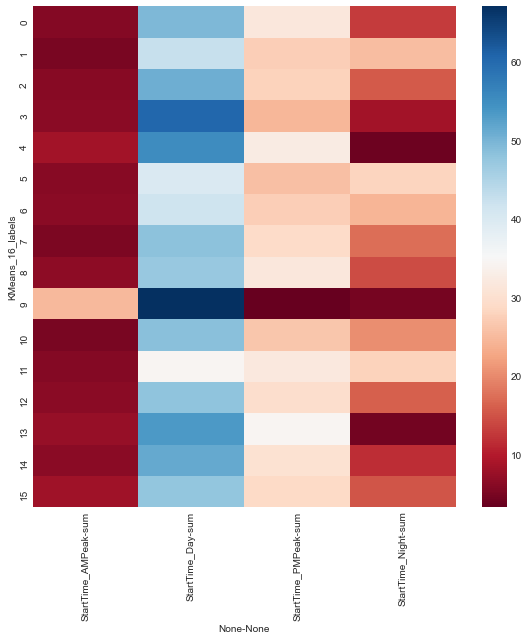

In [50]:
style.use('seaborn-darkgrid')

summary_time_day_prop=summary_time_day.apply(lambda x :100 * x / float(x.sum()), axis=1)

fig, ax = plt.subplots(figsize=(8, 9))
p = sns.heatmap(summary_time_day_prop,cmap='RdBu', ax=ax)  #RdBu

plt.tight_layout()

## Temporal distrubution

In [ ]:
selected_cluster = 'kmeans_16'
rolling_avg_data = pd.merge(kmean_results[['trip_id', selected_cluster]],
                          trip_data[['trip_id', 'startDateTime']],
                          on='trip_id',
                          how='inner').set_index('startDateTime')


rolling_avg_data['reclassified_cluster'] = rolling_avg_data.apply(
    lambda x: reclassify_cluster(x[selected_cluster]), axis=1)


rolling_avg_data1=rolling_avg_data.reset_index()






frame_reclassify = {}
for i in np.arange(0, int(len(reclassify_cluster_label)), 1):
#     print(i)
    frame_reclassify.update({
        str(reclassify_cluster_label[i]):
        rolling_avg_data[rolling_avg_data['reclassified_cluster'] ==
                         i].index.value_counts().resample('D').sum()
    })
    
rolling_avg_df = pd.DataFrame(frame_reclassify,index=pd.date_range('2018-9-1', periods=365, freq='D'))
rolling_avg_df = rolling_avg_df.fillna(0)
rolling_avg_df.head()

### Time of the year

#### by numbers

In [ ]:
style.use('seaborn-darkgrid')
sns.set_palette("deep")
from matplotlib.dates import DateFormatter
# custom_palette=sns.color_palette("deep", 5)
fig, ax = plt.subplots(figsize=(10, 5))
for i in rolling_avg_df.columns:
    plt.plot(rolling_avg_df[i].rolling(21,center=True).mean(), label=i)

date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

#axis label
plt.xlabel('Time of the year', fontsize=13)
plt.ylabel('Average daily trips', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfYear.png', dpi=300)
plt.legend()

#### by percentage

In [ ]:
total_trips_by_grouped_cluster=kmean_results.groupby(
    selected_cluster_to_group[0]).size()

rolling_avg_by_percent=rolling_avg_df.div(list(total_trips_by_grouped_cluster))*100

In [ ]:
style.use('seaborn-darkgrid')
sns.set_palette("deep")
from matplotlib.dates import DateFormatter
# custom_palette=sns.color_palette("deep", 5)
fig, ax = plt.subplots(figsize=(10, 5))
for i in rolling_avg_df.columns:
    plt.plot(rolling_avg_by_percent[i].rolling(21, center=True).mean(),
             label=i)

date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

#axis label
plt.xlabel('Time of the year', fontsize=13)
plt.ylabel('Percentage of usage-grouped trips per day', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfYearV2.png',
            dpi=300)
plt.legend()

### Day of the week

In [ ]:
# week_no_value=6
def relabeled_weekno(week_no_value):
    if week_no_value<4:
        return 0
    elif week_no_value==4:
        return 1
    else:
        return week_no_value-3
    

index_array = [np.arange(0, 4, 1), np.arange(0, 24, 1)]
cluster_time_summary = pd.DataFrame(index=pd.MultiIndex.from_product(
    index_array, names=('week_day', 'hour_no')))

data_all_trips_reidentified = rolling_avg_data1.reset_index()
# kmean_results['reclassified_cluster'].unique()
cluster_time_summary
for i in np.arange(0, int(len(reclassify_cluster_label)), 1):
    plot_data = data_all_trips_reidentified[
        data_all_trips_reidentified['reclassified_cluster'] == i]

    plot_data_count = pd.DataFrame(
        plot_data['startDateTime'].value_counts().resample(
            'H').count()).rename(columns={
                'startDateTime': reclassify_cluster_label[i]
            }).reset_index()

    # #creating column for weekday no

    plot_data_count['week_day'] = plot_data_count.apply(
        lambda x: relabeled_weekno(x['index'].weekday()), axis=1)
    plot_data_count['hour_no'] = plot_data_count.apply(
        lambda x: x['index'].hour, axis=1)

    plot_data_summary = plot_data_count.groupby(
        ['week_day', 'hour_no'])[reclassify_cluster_label[i]].mean()

    cluster_time_summary = pd.merge(cluster_time_summary,
                                    plot_data_summary,
                                    on=['week_day', 'hour_no'],
                                    how='left')
# cluster_time_summary = cluster_time_summary.fillna(0)
cluster_time_summary

In [ ]:
#creating column for weekday no
# data['week_no'] = data.apply(lambda x: x['startDateTime'].weekday(), axis=1)
# data['hour_no'] = data.apply(lambda x: x['startDateTime'].hour, axis=1)
style.use('seaborn-darkgrid')
sns.set_palette("deep")

fig, ax = plt.subplots(figsize=(11, 4))

# for i in np.arange(0, total_clusters, 1):
#     plot_data = kmean_results[kmean_results[selected_cluster] == i]

#     plot_data.groupby(['trip_start_week_no', 'trip_start_hour_no'
#                        ]).size().plot(ax=ax)

cluster_time_summary.plot(ax=ax)

for x in np.arange(0, 24 * 5, 24):
    ax.axvline(x=x, color='red', linewidth=0.9, linestyle='--')

day_label = ['Monday-Thursday', 'Friday', 'Saturday', 'Sunday']
day_label_position=[6,33.8,57.1,81.5]

for x in np.arange(1, 5, 1):
    ax.text(day_label_position[x - 1],#-20 + 0.5 * len(day_label[x - 1]) + 24 * x,
            -50,
            day_label[x - 1],
            color='black',
            fontsize=11)

# axis tick label
# ax.set_yticklabels['12,24']

# ax.xaxis.set_minor_locator(MultipleLocator(6))
# ax.xaxis.set_major_locator(MultipleLocator(12))
# ax.set_xticklabels([0, 0, 12, 24, 12, 24, 12, 24, 12, 24, 24, 24, 24])

plt.xticks(np.arange(0,24*4+6,6),['']+['6 am','12 pm','6 pm','12 am']*4)

#axis label
plt.xlabel('Time of the week', fontsize=13, labelpad=15)
plt.ylabel('Average trip volume per hour', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11,loc='upper left', bbox_to_anchor=(0.04, 1))
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfWeek_V2.png', dpi=300)



## Spatial Distribution

### All trips

In [ ]:
all_cluster_start = trip_data[['trip_id', 'startLatitude', 'startLongitude']]

# all_cluster_end = trip_data[['trip_id', 'endLatitude', 'endLongitude']]

# read last config
with open(str('_Data/kepler config/config_hist_all.json'), 'r') as fp:
    config_1 = json.load(fp)


map_start = keplergl.KeplerGl(height=600,
                              data={'data': all_cluster_start},
                              config=config_1)
# this will save map with provided data and config
map_start.save_to_html(file_name=str('results/spatial plots/all_start_heatmap.html'),
                       read_only=False)


#end points
all_cluster_end = trip_data[['trip_id', 'endLatitude', 'endLongitude']]
rep = {
    "data_start": 'data_end',
    "startLatitude": "endLatitude",
    "startLongitude": "endLongitude",
    "start": "end"
}


def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text


config_end = json.loads(replace_all(json.dumps(config_1), rep))

map_end = keplergl.KeplerGl(height=600,
                            data={'data': all_cluster_end},
                            config=config_end)
# this will save map with provided data and config
map_end.save_to_html(file_name=str('results/spatial plots/all_end_heatmap.html'),
                     read_only=False)

### Clusters

In [ ]:
for cluster_no in np.arange(0, int(len(reclassify_cluster_label)), 1):
#     cluster_no=0
    #slice trips in cluster
    reclass_cluster = rolling_avg_data[rolling_avg_data.reclassified_cluster ==
                                       cluster_no]

    #merge with start and end points
    reclass_cluster_start = pd.merge(
        reclass_cluster, trip_data, on='trip_id',
        how='left')[['trip_id', 'startLatitude', 'startLongitude']]

    reclass_cluster_end = pd.merge(reclass_cluster,
                                   trip_data,
                                   on='trip_id',
                                   how='left')[[
                                       'trip_id', 'endLatitude', 'endLongitude'
                                   ]]

    plot_data_name = str('Reclassfied_cluster' + str(cluster_no))

    # read last config
    with open(str('_Data/kepler config/config_hist.json'), 'r') as fp:
        config_1 = json.load(fp)
        
    config_start = json.loads(
        json.dumps(config_1).replace('Reclassfied_cluster0', plot_data_name))

    #for end config
    rep = {
        "Reclassfied_cluster0": plot_data_name,
        "startLatitude": "endLatitude",
        "startLongitude": "endLongitude",
        "start": "end"
    }

    def replace_all(text, dic):
        for i, j in dic.items():
            text = text.replace(i, j)
        return text

    config_end = json.loads(replace_all(json.dumps(config_1), rep))

    map_start = keplergl.KeplerGl(height=600,
                                  data={plot_data_name: reclass_cluster_start},
                                  config=config_start)
    # this will save map with provided data and config
    map_start.save_to_html(file_name=str('results/spatial plots/Regrouped_C'+str(cluster_no) + '_start_heatmap.html'),
                           read_only=False)

    map_end = keplergl.KeplerGl(height=600,
                                data={plot_data_name: reclass_cluster_end},
                                config=config_end)
    # this will save map with provided data and config
    map_end.save_to_html(file_name=str('results/spatial plots/Regrouped_C'+str(cluster_no) + '_end_heatmap.html'),
                         read_only=False)
    map_start

In [ ]:
map_start

In [ ]:
# ##SAVE CONFIG

# config_hist = map_start.config

# #save the current config
# with open(
#         '_Data/kepler config/config_hist.json',
#         'w') as fp:
#     json.dump(config_hist, fp)

### OD matrix

In [ ]:
for cluster_no in np.arange(0, int(len(reclassify_cluster_label)), 1):
    # cluster_no=3
    #slice trips in cluster
    reclass_cluster = rolling_avg_data[rolling_avg_data.reclassified_cluster ==
                                       cluster_no]

    #merge with start and end points
    reclass_cluster = pd.merge(reclass_cluster,
                               trip_data,
                               on='trip_id',
                               how='left')[[
                                   'trip_id', 'startLatitude',
                                   'startLongitude', 'endLatitude',
                                   'endLongitude'
                               ]].sample(1000)

    plot_data_name = str('Reclassfied_cluster' + str(cluster_no))

    # read last config
    with open('config_OD.json', 'r') as fp:
        config_OD = json.load(fp)
    # config_OD = json.loads(json.dumps(config_1).replace('Reclassfied_cluster0',plot_data_name))

    #for end config
    rep = {
        "Reclassfied_cluster0": plot_data_name,
    }

    #     def replace_all(text, dic):
    #         for i, j in dic.items():
    #             text = text.replace(i, j)
    #         return text

    config_OD_edit = json.loads(replace_all(json.dumps(config_OD), rep))

    map_OD = keplergl.KeplerGl(height=600,
                               data={plot_data_name: reclass_cluster},
                               config=config_OD_edit)
    # this will save map with provided data and config
    map_OD.save_to_html(file_name=str('results/spatial plots/OD_' +
                                      str(cluster_no) + '.html'),
                        read_only=False)

In [ ]:
# map_start.config

# ##SAVE CONFIG

# config_OD = map_start.config

# #save the current config
# with open(
#         '../1_Data/Model results/kmeans/aggressive_cleaning/Visualization/reclassified_kepler/config_OD.json',
#         'w') as fp:
#     json.dump(config_OD, fp)

### Data for Chord diagram

In [ ]:
#slice data
kmeans_results_export = kmean_results[['trip_id', 'reclassified_cluster']]

#label dictionary
regrouped_label_dict = {
    0: 'Daytime short errand',
    1: 'Utilitarian',
    2: 'Evening social',
    3: 'Night-time Entertainment District',
    4: 'Recreational'
}

kmeans_results_export['regrouped_cluster_label'] = kmeans_results_export[
    'reclassified_cluster'].map(regrouped_label_dict)

kmeans_results_export=kmeans_results_export.drop(columns=['reclassified_cluster'])
kmeans_results_export.head()

In [ ]:
# Landuse classification by grid
grid_clf=gpd.read_file('_Data/Landuse data/Shapefiles/LandUse_Classification.shp')
grid_clf_byGrid=grid_clf[['Fishnet_25','Landuse']]
grid_clf_byGrid.head()

In [ ]:
#grid id for trip origin and destination
trip_grid = gpd.read_file('_Data/Landuse data/Shapefiles/Start_end_grid_AllSegment.shp')
trip_grid=trip_grid[['trip_id', 'GRID_ID','GRID_ID_1']].rename(columns={'GRID_ID':'Origin_GRID',
                                                             'GRID_ID_1':'Destination_GRID'})

In [ ]:
#merge
chord_diagram_df = pd.merge(kmeans_results_export,
                            trip_grid,
                            on='trip_id',
                            how='left')
chord_diagram_df['Origin_Landuse'] = chord_diagram_df['Origin_GRID'].map(
    dict(dict(grid_clf_byGrid.values)))
chord_diagram_df['Distination_Landuse'] = chord_diagram_df['Destination_GRID'].map(
    dict(dict(grid_clf_byGrid.values)))
chord_diagram_df

In [ ]:
crosstab_Landuse=pd.crosstab(chord_diagram_df['Origin_Landuse'],
                            [chord_diagram_df['Distination_Landuse']],
                            margins=False)
crosstab_Landuse.to_csv('_Data/Chord diagram/crosstab_landuse.csv')
crosstab_Landuse

In [ ]:
crosstab_Landuse_withUseType=pd.crosstab(chord_diagram_df['Origin_Landuse'],
                            [chord_diagram_df['Distination_Landuse'],chord_diagram_df['regrouped_cluster_label']],
                            margins=False)
crosstab_Landuse_withUseType.to_csv('_Data/Chord diagram/crosstab_landuse_withUseType.csv')
crosstab_Landuse_withUseType